  Preparing metadata (setup.py) ... done


<ipython-input-19-067ab290fcd9>:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM photo LIMIT 3;", conn)



 --- Image 1 ---


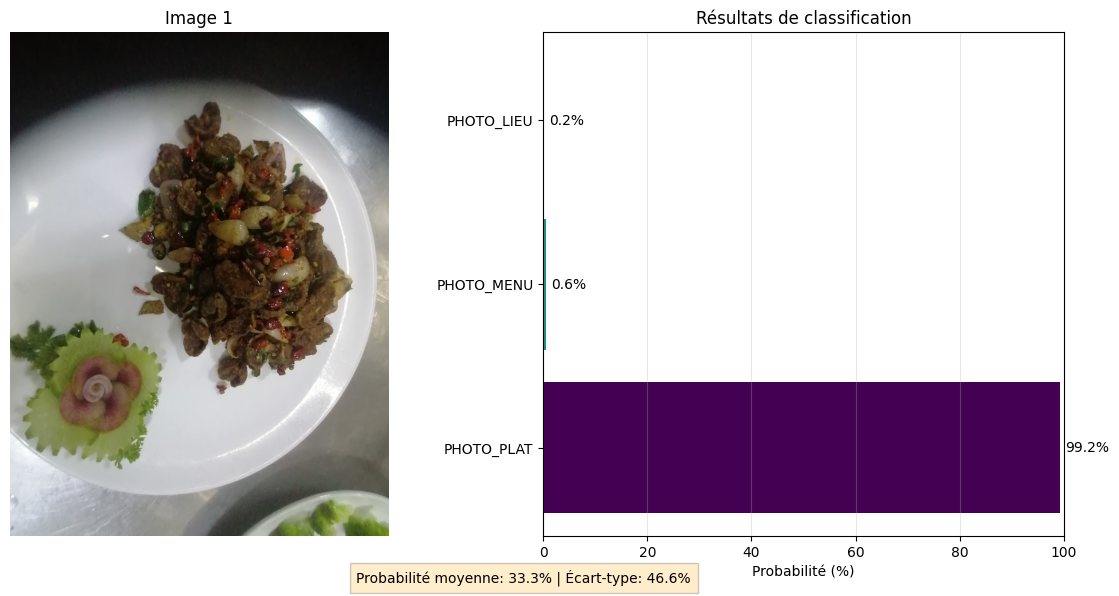


Détail des probabilités :
- PHOTO_PLAT: 99.25%
- PHOTO_MENU: 0.59%
- PHOTO_LIEU: 0.16%
 Catégorie prédite : PHOTO_PLAT

 --- Image 2 ---


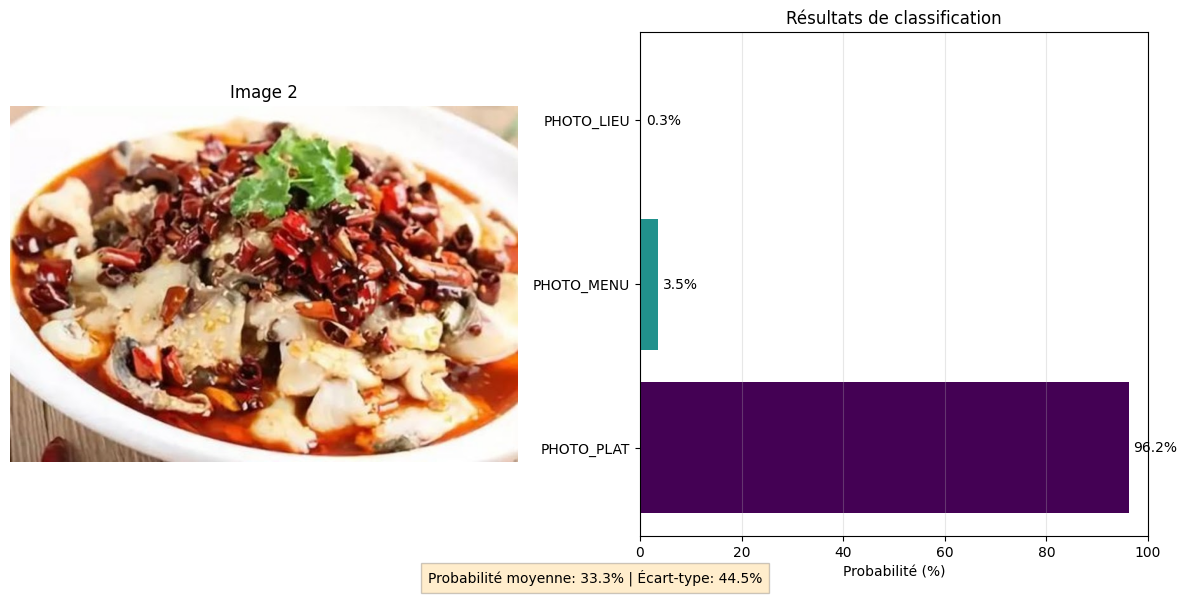


Détail des probabilités :
- PHOTO_PLAT: 96.17%
- PHOTO_MENU: 3.54%
- PHOTO_LIEU: 0.30%
 Catégorie prédite : PHOTO_PLAT

 --- Image 3 ---


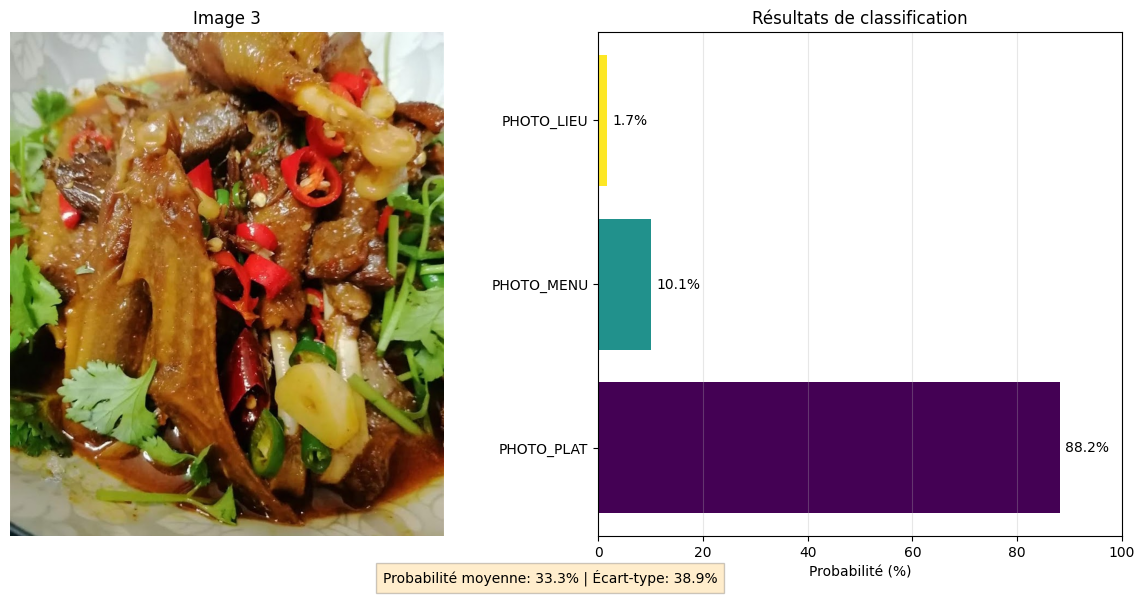


Détail des probabilités :
- PHOTO_PLAT: 88.20%
- PHOTO_MENU: 10.13%
- PHOTO_LIEU: 1.67%
 Catégorie prédite : PHOTO_PLAT


In [19]:
!pip install psycopg2-binary ftfy regex tqdm --quiet
!pip install git+https://github.com/openai/CLIP.git --quiet

import clip
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import base64
import io
import psycopg2

conn = psycopg2.connect(
    host="tramway.proxy.rlwy.net",
    port="25548",
    dbname="railway",
    user="postgres",
    password="bzqQmQwevfpGiQthYwdmzTaBSeLIghrz"
)
df = pd.read_sql("SELECT * FROM photo LIMIT 3;", conn)
conn.close()

def decode_base64_to_image(base64_string):
    image_data = base64.b64decode(base64_string)
    return Image.open(io.BytesIO(image_data)).convert("RGB")

images_pil = [decode_base64_to_image(b64) for b64 in df["photo_data"]]

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

catPourTable = ["PHOTO_PLAT", "PHOTO_MENU", "PHOTO_LIEU"]
categories = [
    "un plat de nourriture",
    "une carte de menu",
    "un intérieur ou extérieur de restaurant"
]
text_inputs = clip.tokenize(categories).to(device)

def predict_image(image, show_plot=True, index=None):
    image_input = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)
        logits_per_image, _ = model(image_input, text_inputs)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()[0]

    if show_plot:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Image {index+1 if index is not None else ''}")

        plt.subplot(1, 2, 2)
        colors = plt.cm.viridis(np.linspace(0, 1, len(categories)))
        bars = plt.barh(catPourTable, probs * 100, color=colors)

        plt.xlim(0, 100)
        plt.xlabel('Probabilité (%)')
        plt.title("Résultats de classification")
        plt.grid(axis='x', alpha=0.3)

        for bar, prob in zip(bars, probs):
            width = bar.get_width()
            plt.text(width + 1, bar.get_y() + bar.get_height() / 2,
                     f'{prob * 100:.1f}%', ha='left', va='center')

        mean_prob = np.mean(probs) * 100
        std_dev = np.std(probs) * 100
        plt.figtext(0.5, 0.02,
                    f"Probabilité moyenne: {mean_prob:.1f}% | Écart-type: {std_dev:.1f}%",
                    ha="center", fontsize=10, bbox={"facecolor": "orange", "alpha": 0.2, "pad": 5})

        plt.tight_layout()
        plt.show()

        print("\nDétail des probabilités :")
        for label, prob in zip(catPourTable, probs):
            print(f"- {label}: {prob * 100:.2f}%")


    return catPourTable[np.argmax(probs)]

for i, img in enumerate(images_pil):
    print(f"\n --- Image {i+1} ---")
    predicted = predict_image(img, show_plot=True, index=i)
    print(f" Catégorie prédite : {predicted}")


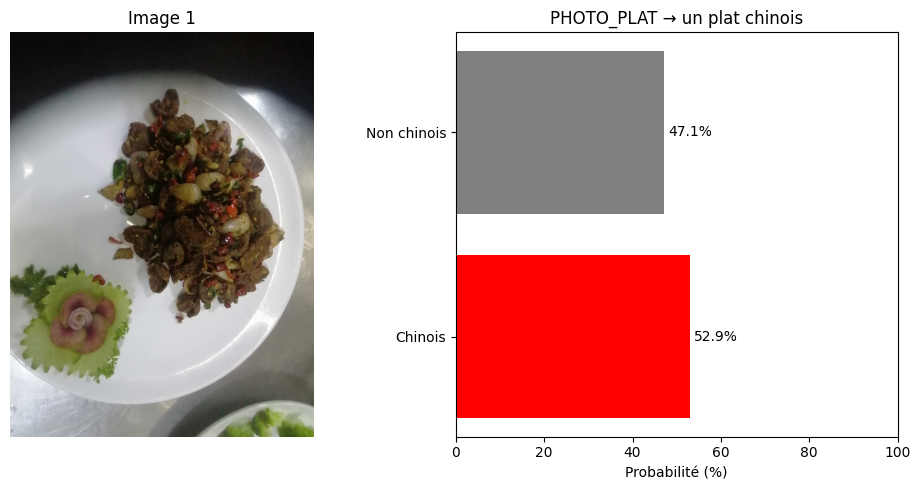

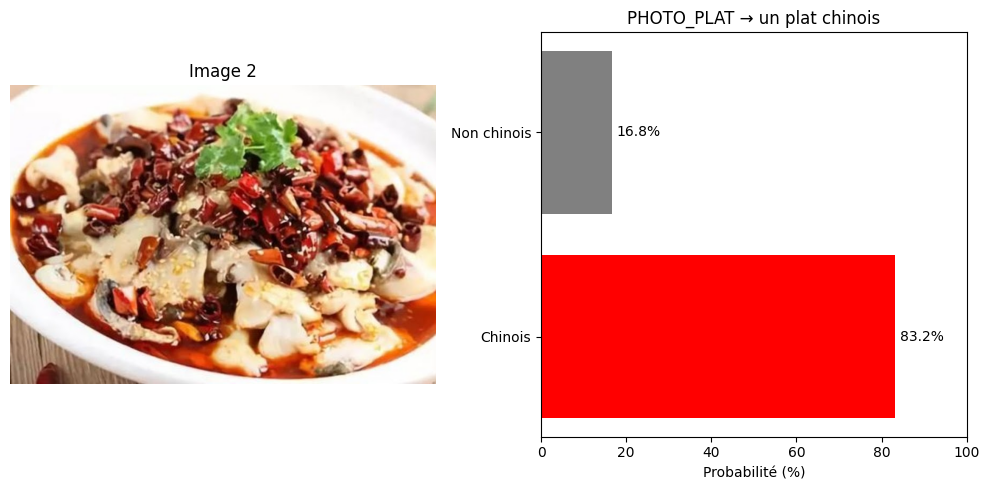

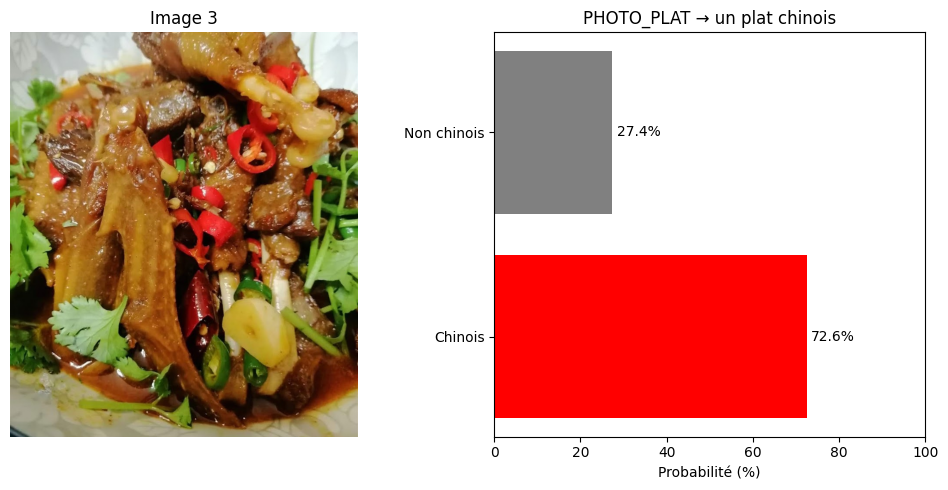

In [9]:
import clip
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

catPourTable = ["PHOTO_PLAT", "PHOTO_MENU", "PHOTO_LIEU"]
categories_type = ["un plat de nourriture", "une carte de menu", "un intérieur ou extérieur de restaurant"]
text_inputs_type = clip.tokenize(categories_type).to(device)

def predict_image_type(image):
    image_input = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        logits, _ = model(image_input, text_inputs_type)
        probs = logits.softmax(dim=-1).cpu().numpy()[0]
    return catPourTable[np.argmax(probs)], probs

def predict_chinois(image, type_image):
    if type_image == "PHOTO_PLAT":
        labels = ["un plat chinois", "un plat non chinois"]
    elif type_image == "PHOTO_MENU":
        labels = ["un menu chinois", "un menu non chinois"]
    else:
        labels = ["un lieu de restaurant chinois", "un lieu de restaurant non chinois"]

    text_inputs = clip.tokenize(labels).to(device)
    image_input = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        logits, _ = model(image_input, text_inputs)
        probs = logits.softmax(dim=-1).cpu().numpy()[0]

    return labels[np.argmax(probs)], probs

results = []
for i, img in enumerate(images_pil):
    type_img, type_probs = predict_image_type(img)
    chinois_label, chinois_probs = predict_chinois(img, type_img)
    results.append({
        "image": img,
        "index": i,
        "type": type_img,
        "type_probs": type_probs,
        "chinois_label": chinois_label,
        "chinois_probs": chinois_probs
    })

for res in results[:4]:
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(res["image"])
    plt.axis('off')
    plt.title(f"Image {res['index']+1}")

    plt.subplot(1, 2, 2)
    labels = ["Chinois", "Non chinois"]
    probs = res["chinois_probs"] * 100
    colors = ['red', 'gray']
    bars = plt.barh(labels, probs, color=colors)

    for bar, prob in zip(bars, probs):
        width = bar.get_width()
        plt.text(width + 1, bar.get_y() + bar.get_height()/2,
                 f'{prob:.1f}%', ha='left', va='center')

    plt.xlim(0, 100)
    plt.title(f"{res['type']} → {res['chinois_label']}")
    plt.xlabel("Probabilité (%)")
    plt.tight_layout()
    plt.show()


In [17]:
import pandas as pd
import psycopg2
import re

conn = psycopg2.connect(
    host="tramway.proxy.rlwy.net",
    port="25548",
    dbname="railway",
    user="postgres",
    password="bzqQmQwevfpGiQthYwdmzTaBSeLIghrz"
)

df = pd.read_sql("""
    SELECT restaurant_id, photo_chinois, proba_chinois
    FROM photo
    WHERE restaurant_id IS NOT NULL;
""", conn)

df_nom = pd.read_sql("""
    SELECT id AS restaurant_id, name
    FROM restaurant;
""", conn)

def contient_ideogramme(nom):
    return bool(re.search(r'[\u4e00-\u9fff]', nom or ""))

motifs_chinois = [
    "chinois", "china", "wok", "dragon", "asie", "asian", "empereur",
    "mandarin", "saigon", "nems", "pho", "szechuan", "viet", "thaï", "sushi"
]

def proba_depuis_nom(nom):
    if not nom:
        return 0.0
    nom = nom.lower()
    score_keywords = sum(1 for motif in motifs_chinois if motif in nom)
    proba_keywords = min(score_keywords / len(motifs_chinois), 1.0)
    bonus_ideogramme = 0.5 if contient_ideogramme(nom) else 0.0
    return min(proba_keywords + bonus_ideogramme, 1.0)

def est_chinois(group, seuil=0.5):
    nb_photos = len(group)
    nb_chinois = sum(group['photo_chinois'] == 'Chinois')
    moyenne_proba = group['proba_chinois'].mean()
    return pd.Series({
        'nb_photos': nb_photos,
        'nb_chinois': nb_chinois,
        'moyenne_proba': moyenne_proba
    })

df_grouped = df.groupby('restaurant_id').apply(est_chinois).reset_index()

df_grouped = df_grouped.merge(df_nom, on='restaurant_id', how='left')
df_grouped['proba_nom'] = df_grouped['name'].apply(proba_depuis_nom)

def decision_finale(row, seuil_img=0.4, seuil_nom=0.4):
    return (
        (row['nb_chinois'] > 0 and row['moyenne_proba'] > seuil_img) or
        (row['proba_nom'] >= seuil_nom)
    )

df_grouped['is_chinois'] = df_grouped.apply(decision_finale, axis=1)

ids_avec_photo = set(df_grouped['restaurant_id'])
df_sans_photo = df_nom[~df_nom['restaurant_id'].isin(ids_avec_photo)].copy()

df_sans_photo['nb_photos'] = 0
df_sans_photo['nb_chinois'] = 0
df_sans_photo['moyenne_proba'] = 0.0
df_sans_photo['proba_nom'] = df_sans_photo['name'].apply(proba_depuis_nom)
df_sans_photo['is_chinois'] = df_sans_photo['proba_nom'] >= 0.4

df_final = pd.concat([df_grouped, df_sans_photo], ignore_index=True)

cur = conn.cursor()
update_query = """
    UPDATE restaurant
    SET is_chinois = %s
    WHERE id = %s;
"""
update_data = [(row['is_chinois'], int(row['restaurant_id'])) for _, row in df_final.iterrows()]
cur.executemany(update_query, update_data)
conn.commit()
cur.close()

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)

print(f"\n {len(update_data)} restaurants mis à jour avec le champ is_chinois.")
print("\n Résultats détaillés :")
print(df_final[['restaurant_id', 'name', 'nb_photos', 'nb_chinois', 'moyenne_proba', 'proba_nom', 'is_chinois']])

df_final[['restaurant_id', 'name', 'nb_photos', 'nb_chinois', 'moyenne_proba', 'proba_nom', 'is_chinois']].to_csv("restaurants_classification.csv", index=False)
print("\n Résultats enregistrés dans 'restaurants_classification.csv'")

conn.close()


<ipython-input-17-73c26245fa88>:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("""
<ipython-input-17-73c26245fa88>:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_nom = pd.read_sql("""
<ipython-input-17-73c26245fa88>:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_grouped = df.groupby('restaurant_id').apply(est_chinois).reset_index()



✅ 82 restaurants mis à jour avec le champ is_chinois.

📋 Résultats détaillés :
    restaurant_id                                               name  nb_photos  nb_chinois  moyenne_proba  proba_nom  is_chinois
0               1                                         吕府私房菜（KTV）       10.0         9.0       0.688436   0.500000        True
1               2                  Sweet Talk by Coq d'Or (Boutique)        1.0         0.0       0.095195   0.000000       False
2               6                                     O Loft Chinois       10.0         4.0       0.400609   0.066667        True
3               7                Restaurant L'EURASIE - Ankorondrano       10.0         2.0       0.381588   0.066667       False
4               8                                   Le Petit Bouchon       10.0         8.0       0.616054   0.000000        True
5               9                                          Dun Huang       10.0         8.0       0.612961   0.000000        True
6         